공동 발의 및 개인 발의 법안 현황으로 의원들간 서브 그룹 분석하기
===========

의원들의 군집을 파악하고자, 비지도 학습 중 계층적 클러스터링을 택했습니다. 데이터의 알려지지 않은 서브 그룹들을 발견하기 위한 방법 중 하나 입니다.
---------------

In [1]:
setwd('C:/Users/User/Desktop/마이닝/exam')

In [2]:
dev.off()
rm(list = ls())

null device 
          1

In [3]:
library(readxl)

clust_profile <- read_excel("data2.xlsx",sheet = "Sheet3", na = "NA", col_names = TRUE, col_types = "guess" )

Warning message:
"package 'readxl' was built under R version 3.4.2"

행과 열의 hearder를 만들어주는 과정입니다.

In [5]:
df=data.frame(clust_profile)
rownames(df)=df[,1]
df=df[,-1]
ma=as.matrix(df)

data2의 수치들을 의원들간 '거리'로 설정 후 분석을 진행하고자 모두 역수화했습니다. 의원들간 공동발의 법안의 갯수를 '유사도'라 본다면, 그들간의 '거리'는 '유사도'에 반비례한다고 가정했습니다. 즉, 함께 발의한 법안이 많을수록 그들간의 '거리'는 가까워집니다.함께 발의한 법안이 0건인 경우, 공동 발의 이력이 1건 이상인 의원들 간 최대거리 1보다 먼 2로 할당했습니다.

또한 자기 자신과의 거리는 0으로 바꾸고자 단독 발의 법안 수인 대각원소를 0으로 수정하였습니다.

In [6]:
df_inverse=df

i=1
j=1

for (i in 1:nrow(df)){
  for(j in 1:ncol(df)){
    df_inverse[i,j]=1/df[i,j]
    if (is.infinite(df_inverse[i,j])==TRUE){
      df_inverse[i,j]=2   #0면 거리 2인 것으로.
    }

  }
}

diag(df_inverse) <- 0

계층적 클러스터링을 진행하였습니다. 거리 측정 방법으로 가장 보편적으로 쓰이는 complete, single, average 3가지를 활용했습니다. 거리측정 방법이 덴드로그램 결과에 영향을 준다는 것을 볼 수 있습니다. complete 방식이 군집들의 내부 응집성에 중점을 둔 방법일 뿐만 아니라, 가장 균형잡힌 클러스터를 생성하고 있습니다. 이에 complete 계층적 클러스터링을 사용해 분석을 진행합니다.

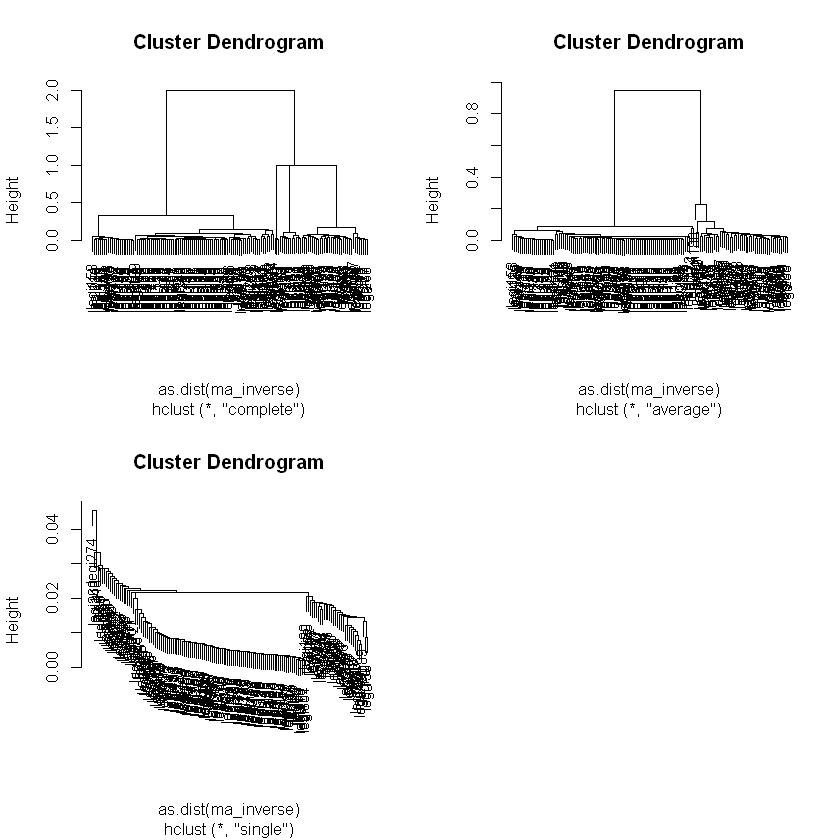

In [19]:
ma_inverse=as.matrix(df_inverse)
hc.complete=hclust(as.dist(ma_inverse), method="complete")
hc.average=hclust(as.dist(ma_inverse), method="average")
hc.single=hclust(as.dist(ma_inverse), method="single")

par(mfrow=c(2,2))
plot(hc.complete, cex=.9)
plot(hc.average, cex=.9)
plot(hc.single, cex=.9)

다음은 덴드로그램 절단 위치, 즉 클러스터 생성 개수를 결정하기 위한 작업입니다. 먼저 데이터가 잘 클러스터링 되어있는지를 확인할 수 있는 '실루엣'을 그려봅니다. 2개의 군집으로 분류할 때가 Silhouette width s 가 가장 높게 나타나 가장 바람직한 군집 개수라 제시하고 있습니다. 

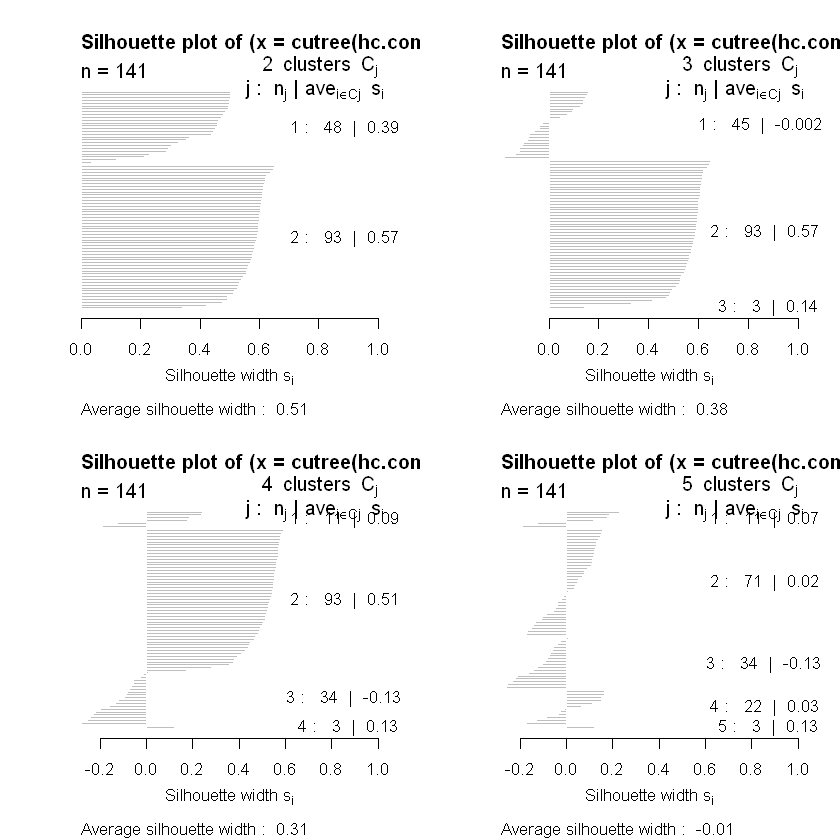

In [8]:
library(cluster)
par(mfrow = c(2,2))
plot(silhouette(cutree(hc.complete, k=2),dist = dist(df_inverse), col = 1:10))
plot(silhouette(cutree(hc.complete, k=3),dist = dist(df_inverse), col = 1:10))
plot(silhouette(cutree(hc.complete, k=4),dist = dist(df_inverse), col = 1:10))
plot(silhouette(cutree(hc.complete, k=5),dist = dist(df_inverse), col = 1:10))

2개의 군집 형성하며 절단을 진행합니다. 이어 의원별 소속정당 정보를 넣고 2개의 군집으로 분류 결과를 확인해 봅니다.

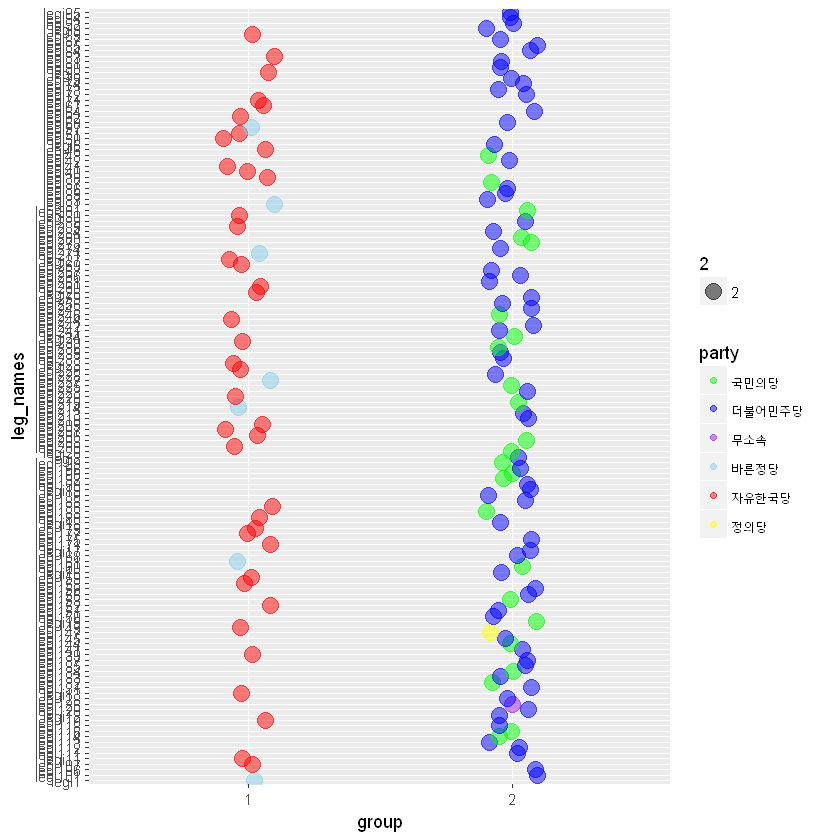

In [9]:
hc.complete_cut=cutree(hc.complete, 2)
name_leg=names(hc.complete_cut)
hc.complete_cut_name=cbind(hc.complete_cut,name_leg)
colnames(hc.complete_cut_name)<-c('group','leg_names')
hc.complete_cut_name_df=as.data.frame(hc.complete_cut_name)
cust_profile2 <- read_excel("data2.xlsx",sheet = "party", na = "NA", col_names = TRUE, col_types = "guess" ) 
df_party=as.data.frame(cust_profile2)
colnames(df_party)<-c('leg_names','party')
hc.complete_cut_name_df_merged=merge.data.frame(hc.complete_cut_name_df,df_party)

library(ggplot2)
myColors <- c("green", "blue", "purple", "sky blue", "red", "yellow")
ggplot(data=hc.complete_cut_name_df_merged, aes(x=group,y=leg_names, color = party, size = 2)) + geom_point(position = position_jitter(w = 0.1, h = 0),alpha=.5) + scale_color_manual(values=myColors)


2개의 군집으로 분류하였을 때, 자유한국당과 바른정당 / 국민의당, 더불어민주당, 무소속, 정의당 이렇게 두 진영으로 나누어집니다. 그룹 1은 보수성향의 정당, 그룹2는 진보성향의 정당임을 확인할 수 있습니다.

하지만 2개의 군집 형성에 그치지 않고 추가적인 절단을 이어가려 합니다.
국내 정치 실정을 고려하였을 때, 야당 내, 야당 간 이합집산이 여당 견제를 위해 많이 이루어지고 있기 때문입니다.
우선 complete 거리측정법으로 그린 덴드로그램에서 5개의 군집이 유의미하게 이루어질 수 있음을 볼 수 있습니다.
또한 K-평균 군집 형성 전 쓰이는, 군집 수에 따른 집단 내 제곱합을 확인하는 작업으로도 5개의 군집 형성이 제시됨을 볼 수 있습니다.
군집 수가 5일 때 오차 제곱합을 가장 효율적으로 줄일 수 있기 때문입니다.

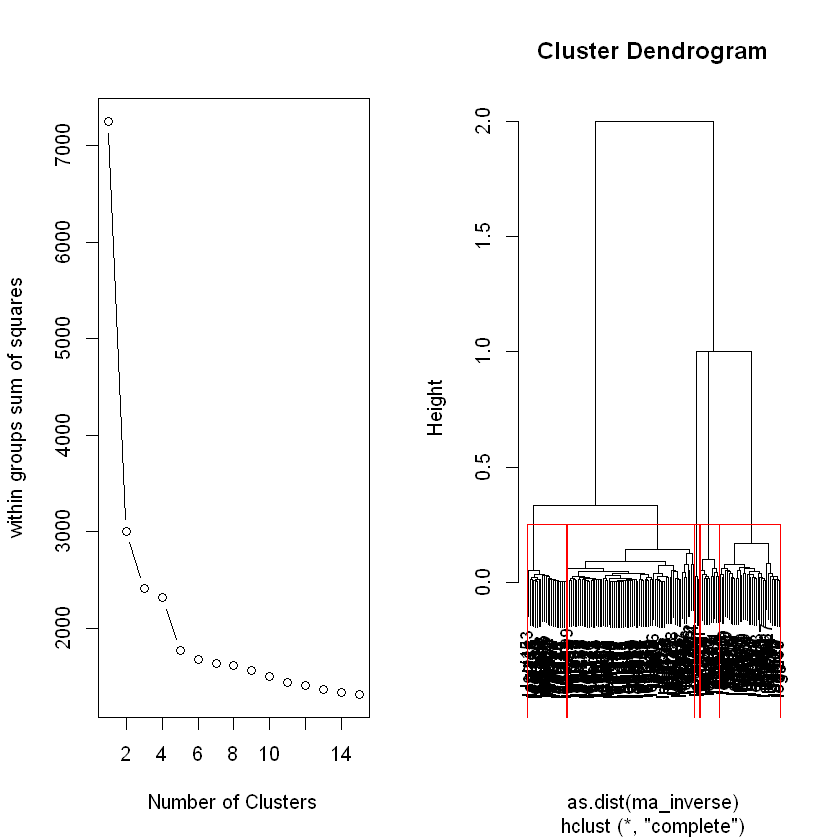

In [15]:
par(mfrow = c(1, 2))
cor.leg <- df_inverse

wssplot <- function(data, nc=15, seed=1234){
  wss <- (nrow(data) - 1) * sum(apply(data, 2, var))
  for (i in 2:nc){
    set.seed(seed)
    wss[i] <- sum(kmeans(data, centers=i)$withinss)}
  plot(1:nc, wss, type = 'b', xlab = 'Number of Clusters',
       ylab = 'within groups sum of squares')}

wssplot(cor.leg)

plot(hc.complete, cex=.9)
rect.hclust(hc.complete, k = 5, border = 'red')

이에 5개의 계층적 군집형성을 진행 후 시각화 해봅니다.

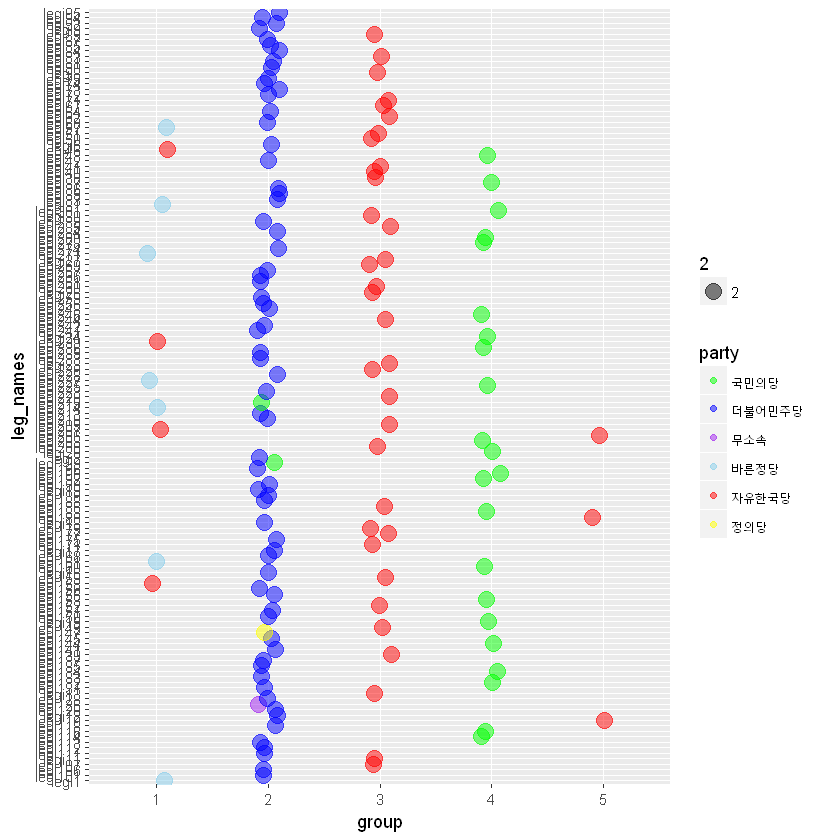

In [16]:
hc.complete_cut=cutree(hc.complete, 5)
name_leg=names(hc.complete_cut)
hc.complete_cut_name=cbind(hc.complete_cut,name_leg)
colnames(hc.complete_cut_name)<-c('group','leg_names')
hc.complete_cut_name_df=as.data.frame(hc.complete_cut_name)
cust_profile2 <- read_excel("data2.xlsx",sheet = "party", na = "NA", col_names = TRUE, col_types = "guess" ) 
df_party=as.data.frame(cust_profile2)
colnames(df_party)<-c('leg_names','party')
hc.complete_cut_name_df_merged=merge.data.frame(hc.complete_cut_name_df,df_party)

library(ggplot2)
myColors <- c("green", "blue", "purple", "sky blue", "red", "yellow")
ggplot(data=hc.complete_cut_name_df_merged, aes(x=group,y=leg_names, color = party, size = 2)) + geom_point(position = position_jitter(w = 0.1, h = 0),alpha=.5) + scale_color_manual(values=myColors)


5개의 군집으로 계층적 클러스터링을 시행한 결과, 위의 그림과 같이 

1. 바른정당과 일부의 자유한국당 의원으로 형성된 그룹1
2. 더불어 민주당과 일부의 국민의당 의원, 정의당 및 무소속 의원으로 형성된 그룹2
3. 주류 자유한국당 의원으로 구성된 그룹3
4. 주류 국민의당 의원으로 구성된 그룹3
5. 소수의 자유한국당 의원으로 형성된 그룹5

로 군집이 형성되었습니다.

위에 plot으로 시각화된 이미지와 덴드로그램에 나타난 집단 간 거리를 분석해 몇가지 결과를 정리할 수 있습니다.

1. 기본적으로 그룹 4와 2, 즉 국민의당과 더불어민주당은 진보의 성격을 띄고 있지만, 국민의당의 견제 등 차별화를 보이는 움직임으로 인해 동일 집단으로 볼 수 없는 것으로 예측됩니다.
2. 또한 자유한국당과 바른정당은 기본적으로 보수의 성격을 지닌 정당들이지만, 바른정당은 '합리적 보수'를 외치며 자유한국당과 스탠스를 달리하는 모습을 볼 수 있습니다.
3. 일부 자유한국당 의원들은 주류 세력에 반하여 다른 스탠스를 가지고 있음이 포착됩니다.
4. 정의당과 무소속 의원은 더불어민주당과 같은 스탠스를 취하고 있습니다.
5. 덴드로그램의 군집 간 거리로 보아, 보수(그룹 1, 3, 5) 정당과 진보(그룹 2, 4) 사이 법안 발의 협력은 제대로 이루어지고있지 않는 것으로 보입니다. 
6. 더불어민주당은 소속 의원 수를 고려해보았을 때, 그 어느 당보다도 당내 결속이 강하게 이루어지고 있음을 알 수 있습니다.

In [20]:
answer <- as.matrix(hc.complete_cut_name_df_merged)
answer

leg_names,group,party
legi1,1,바른정당
legi101,2,더불어민주당
legi106,2,더불어민주당
legi107,3,자유한국당
legi11,3,자유한국당
legi111,2,더불어민주당
legi112,2,더불어민주당
legi113,2,더불어민주당
legi114,4,국민의당
legi116,4,국민의당


In [18]:
write.csv(answer, file = 'clustering_Q4.csv')